# Tasso di Positività

Calcolo del Tasso di Positività.

> Max Pierini, Sandra Mazzoli, Alessio Pamovio

Pubblicazioni:

- [L'Espresso](http://fino-a-prova-contraria.blogautore.espresso.repubblica.it/2020/08/31/roma-uno-studio-sul-tasso-di-positivita-di-covid-19-in-italia/?fbclid=IwAR3KmXHt3RVYZvUgrRNO58kWlJ9_u4j0l-MIq5Bqsou96-i2-B6wHQcRXc4)

Il Tasso di Positività **PP** (dall'inglese _Percent Positive_) <cite data-cite="jhu2020"></cite> <cite data-cite="ellis2020"></cite> <cite data-cite="boyce2016practical"></cite> è calcolato come _nuovi test positivi_ sul _totale dei nuovi test effettuati_, è quindi una percentuale che indica quanti, tra i test (tamponi) effettuati giornalmente, sono risultati positivi rispetto al totale dei soggetti testati. Può essere considerato come un indice della trasmissione delle malattie infettive ed è estesamente usato per stimarne l'incidenza (quantità di nuovi casi in un determinato lasso di tempo). Se è maggiore della soglia di allarme, indica anche che il numero di test effettuati non è sufficiente ad individuare tutti i nuovi casi giornalieri ed è quindi necessario sottoporre più persone ai test.
La "soglia di allarme" per **PP** (area rossa nel grafico) di COVID-19 è stata stabilita al 5% <cite data-cite="jhu2020"></cite>. L'Organizzazione Mondiale della Sanità ha, per esempio, raccomandato di rilassare gli interventi non farmacologici (lockdown, distanziamento sociale, ecc) per COVID-19 solo dopo che il **PP** sia stato osservato al di sotto della soglia di allarme per almeno due settimane. 

Come gruppo di studio e analisi dei dati COVID-19, abbiamo ritenuto opportuno aggiungere una "soglia di allerta" al 3% (area gialla nel grafico): se il **PP** aumenta al di sopra del 3% mostrando un andamento in crescita si può supporre un prossimo verosimile scenario di allarme.

Questi indici aiutano nel definire il quadro della situazione epidemiologica, la sua verosimile prossima evoluzione e influenzano le decisioni politiche, sociali ed economiche.

Ad esempio, un $R_t$ sopra 1 unito ad un **PP** maggiore del 5%, sono fortemente indicativi di una grave situazione che necessita al più presto di interventi politici, sociali e medici. Al contrario un $R_t$ minore di 1 e un **PP** al di sotto della soglia di allerta mostrano una situazione in via di risoluzione.

> N.B. abbiamo scelto di calcolare il **PP** usando i nuovi casi testati (soggetti mai testati prima) anziché i nuovi tamponi totali, comprendendo i tamponi totali anche i test ripetuti (controllo e follow-up) su pazienti già risultati positivi in precedenza

I dati grezzi sono 

- filtrati con _Hampel filter_, finestra gaussiana di 7 giorni, $\sigma=2$ per isolare gli outliers dal trend
- smussati con media mobile, finestra gaussiana di 14 giorni, $\sigma=5$ per evidenziare il trend

***

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker as mtick
from IPython.display import HTML, Markdown, Latex

In [2]:
it = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv",
     usecols=['data', 'nuovi_positivi', 'totale_casi', 'casi_testati', 'tamponi'],
     parse_dates=['data'],
     index_col=['data'],
     squeeze=True).sort_index()
ok = it[it['casi_testati']>0]

In [3]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",
     usecols=['data', 'denominazione_regione', 'nuovi_positivi', 'casi_testati'],
     parse_dates=['data'],
     index_col=['denominazione_regione', 'data'],
     squeeze=True).sort_index()

ko = df[df['casi_testati']>0]
countries = ko.index.get_level_values("denominazione_regione").unique().sort_values()
days = ko.index.get_level_values("data").unique()
tot_days = it.index.get_level_values("data").unique()

In [4]:
# find and fix outliers using Hampel filter
# Impl from: https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d

def hampel_filter_pandas(input_series, window_size, n_sigmas=3.0):

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    # the use of min_periods is to have rolling window extend towards
    # the end of the data series; in effect, we can apply hampel filter
    # to most recent observations
    # taken from: https://stackoverflow.com/questions/48953313/pandas-rolling-window-boundary-on-start-end-of-series/48953314#48953314
    rolling_window_size = 2*window_size+1
    rolling_median = input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).median()
    rolling_mad = k * input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).apply(MAD)
    # print(f'rolling_mad = {rolling_mad}, rolling_median = {rolling_median}')
    diff = np.abs(input_series - rolling_median)
    
    where = diff > (n_sigmas * rolling_mad)
    indices = np.argwhere(where.to_numpy()).flatten()
    new_series[indices] = rolling_median[indices]
    
    return new_series, indices

# Italia

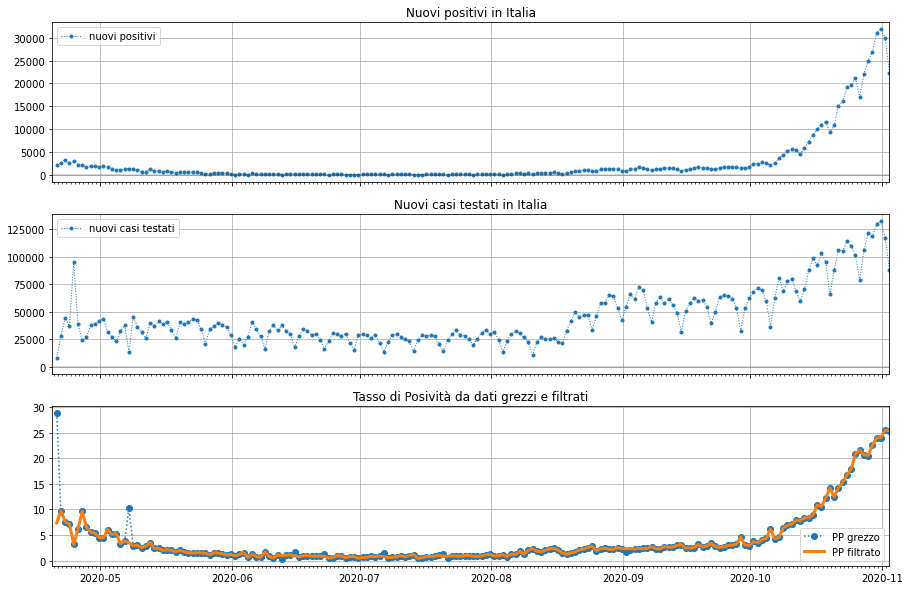

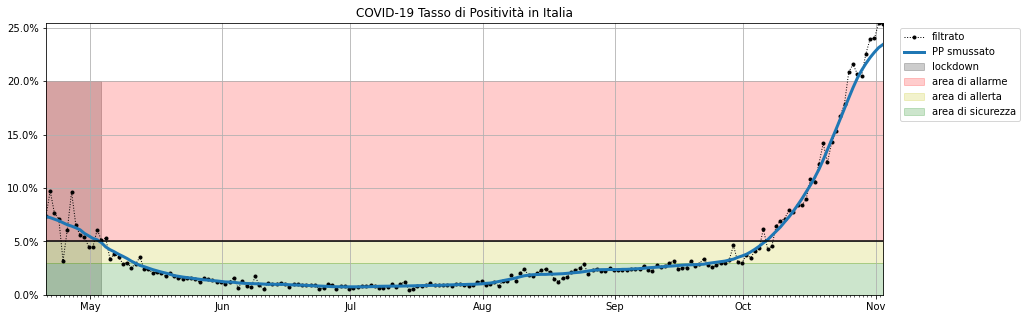

In [5]:
#pos, pos_outs = hampel_filter_pandas(ok['nuovi_positivi'][1:], 7, n_sigmas=2.0)
#tst, tst_outs = hampel_filter_pandas(ok['casi_testati'].diff()[1:], 7, n_sigmas=2.0)

#tst[tst==0] = np.nan

grezzo = ok.nuovi_positivi[1:] / ok.casi_testati.diff()[1:] * 100
indice, pp_outs = hampel_filter_pandas(grezzo, 7, n_sigmas=2.0)
smooth = indice.rolling(14,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=5).values

fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

ax[0].plot(ok['nuovi_positivi'][1:], 'o:', ms=3, lw=1, label="nuovi positivi")
#pos.plot(ax=ax[0], lw=3)
ax[0].grid()
ax[0].axhline(0, c="k", alpha=.2)
ax[0].legend()
ax[0].set_title("Nuovi positivi in Italia")

ax[1].plot(ok['casi_testati'].diff()[1:], 'o:', ms=3, lw=1, label="nuovi casi testati")
#tst.plot(ax=ax[1], lw=3)
ax[1].axhline(0, c="k", alpha=.2)
ax[1].grid()
ax[1].legend()
ax[1].set_xlim(days[0], days[-1])
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1].xaxis.set_minor_locator(mdates.DayLocator())
ax[1].set_title("Nuovi casi testati in Italia")

ax[2].plot(grezzo.index, grezzo, 'o:', label="PP grezzo")
ax[2].plot(indice.index, indice, lw=3, label="PP filtrato")
ax[2].grid()
ax[2].legend()
ax[2].set_title("Tasso di Posività da dati grezzi e filtrati")

plt.show()
plt.close(fig="all")

####

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(indice, 'ok:', label="filtrato", lw=1, ms=3)
ax.plot(indice.index, smooth, lw=3, label="PP smussato")

#ax.hlines(np.arange(0,15,1), indice.index[0], indice.index[-1], color="k", alpha=.2)

ax.axhline(5, c="k")

ax.fill_betweenx(
    [0,20],
    indice.index[indice.index>=pd.to_datetime("2020-03-11")][0],
    indice.index[indice.index<=pd.to_datetime("2020-05-04")][-1],
    color="k", alpha=.2, label="lockdown"
)
ax.grid()
ax.fill_between(indice.index, 5, 20, color="r", alpha=.2, label="area di allarme")
ax.fill_between(indice.index, 3, 5, color="y", alpha=.2, label="area di allerta")
ax.fill_between(indice.index, 0, 3, color="g", alpha=.2, label="area di sicurezza")


ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylim(0, max(10, indice.max()))
ax.set_xlim(indice.index[0], indice.index[-1])

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_minor_locator(mdates.DayLocator())

ax.legend(loc="upper right", bbox_to_anchor=(1.17,1))
ax.set_title("COVID-19 Tasso di Positività in Italia")
fig.set_facecolor('w'); plt.show();

In [6]:
idf = pd.DataFrame({
    "data":indice.index[-7:],
    "PP grezzo":grezzo.values[-7:],
    "PP filtrato":indice.values[-7:],
    "PP smussato":smooth[-7:]
})
idf.set_index('data', inplace=True)
display(HTML(idf[::-1].to_html()))

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,25.384712,25.384712,23.443176
2020-11-01 17:00:00,25.457532,25.457532,23.153062
2020-10-31 17:00:00,24.008346,24.008346,22.718091
2020-10-30 17:00:00,23.968293,23.968293,22.224695
2020-10-29 17:00:00,22.574186,22.574186,21.657651
2020-10-28 17:00:00,20.514694,20.514694,21.024100
2020-10-27 17:00:00,20.681549,20.681549,20.286925


***

# Regioni

## Abruzzo

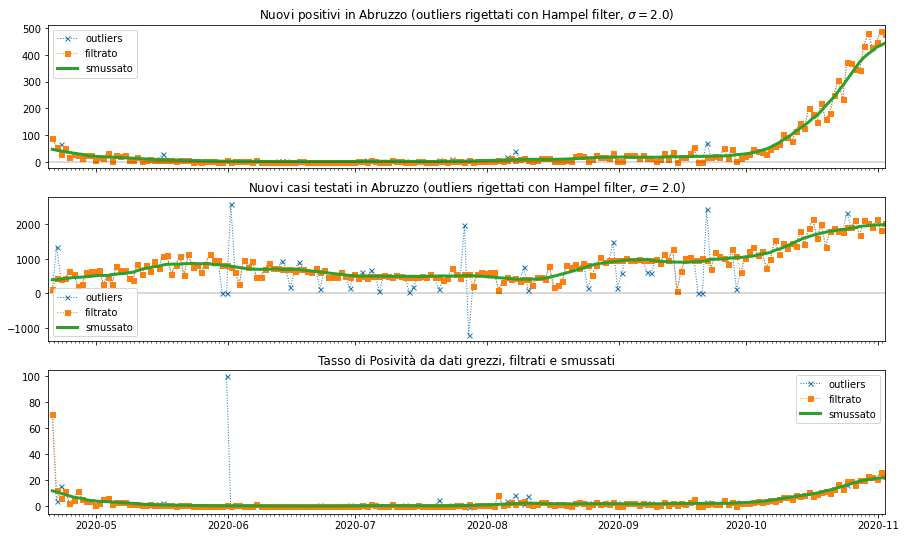

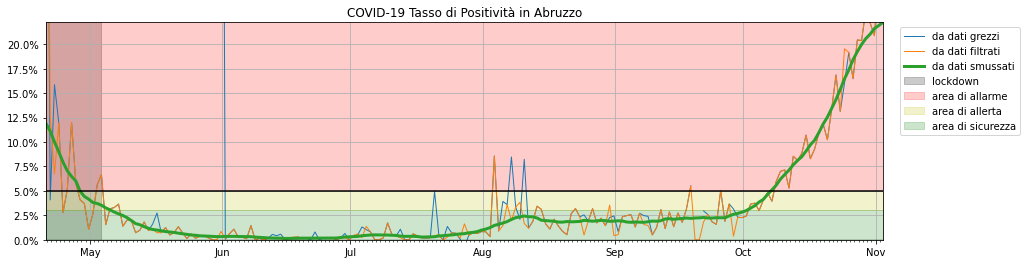

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,23.374083,23.374083,22.240059
2020-11-01 17:00:00,26.633987,26.633987,21.910739
2020-10-31 17:00:00,20.881671,20.881671,21.607660
2020-10-30 17:00:00,22.187662,22.187662,21.037413
2020-10-29 17:00:00,23.535156,23.535156,20.588935
2020-10-28 17:00:00,20.385157,20.385157,19.985722
2020-10-27 17:00:00,20.438389,20.438389,19.246558


***

## Basilicata

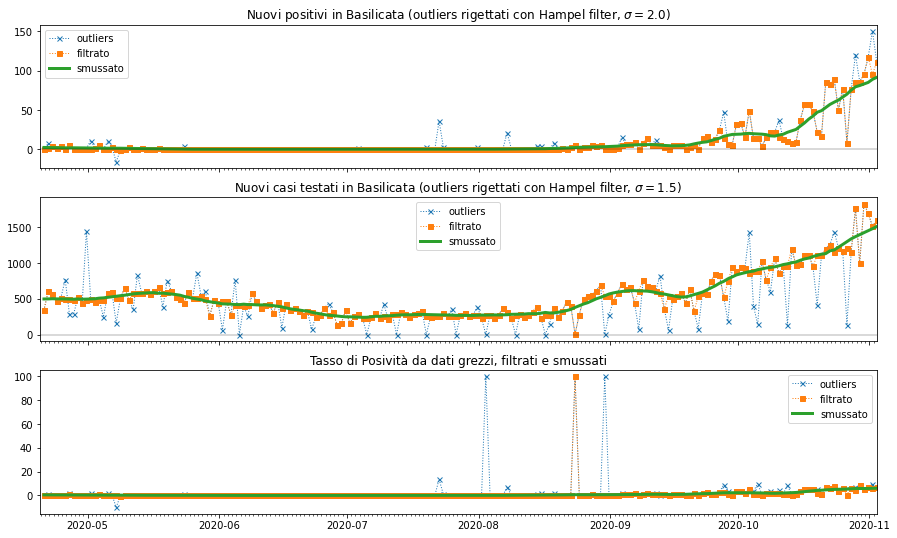

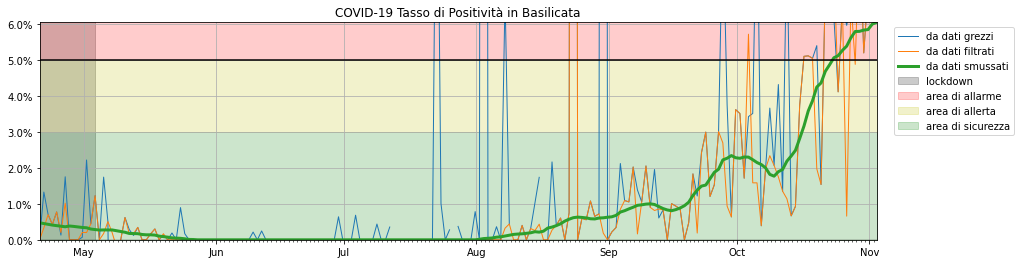

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,6.946183,6.946183,6.053326
2020-11-01 17:00:00,9.927201,6.287227,6.005153
2020-10-31 17:00:00,6.910809,6.910809,5.852396
2020-10-30 17:00:00,5.202629,5.202629,5.838225
2020-10-29 17:00:00,8.651911,8.651911,5.802664
2020-10-28 17:00:00,6.814310,4.883589,5.798949
2020-10-27 17:00:00,6.649396,6.649396,5.627807


***

## Calabria

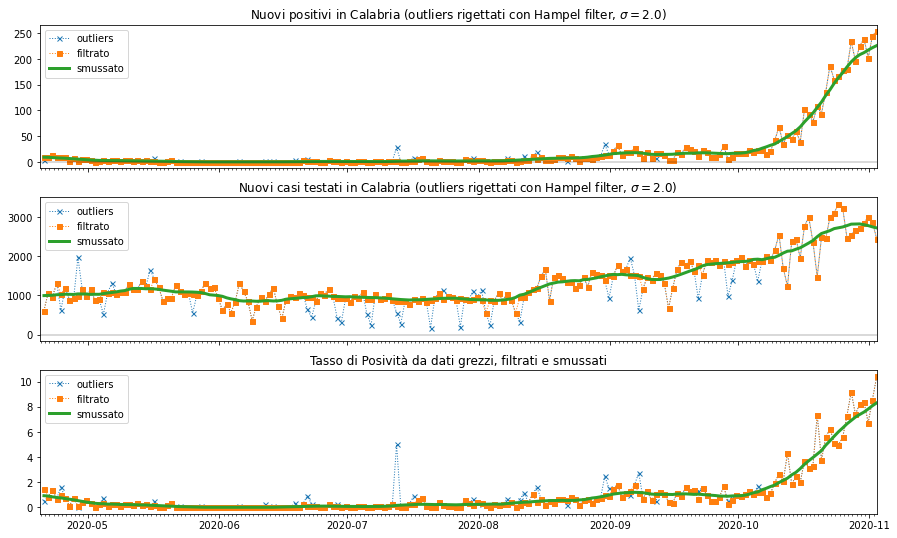

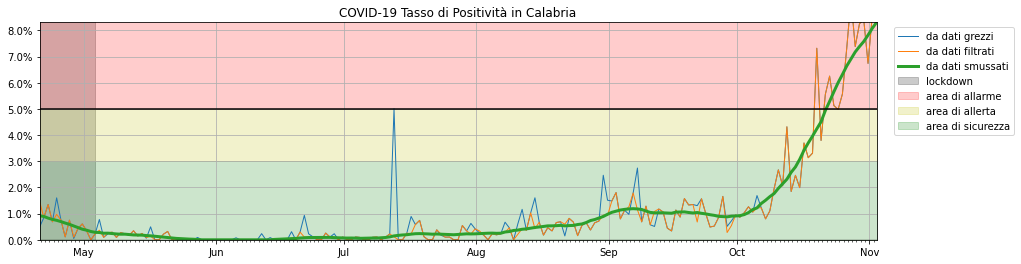

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,10.409836,10.409836,8.306006
2020-11-01 17:00:00,8.563439,8.563439,8.080755
2020-10-31 17:00:00,6.737825,6.737825,7.819311
2020-10-30 17:00:00,8.400703,8.400703,7.575317
2020-10-29 17:00:00,8.256881,8.256881,7.383828
2020-10-28 17:00:00,7.382298,7.382298,7.176060
2020-10-27 17:00:00,9.190888,9.190888,6.903762


***

## Campania

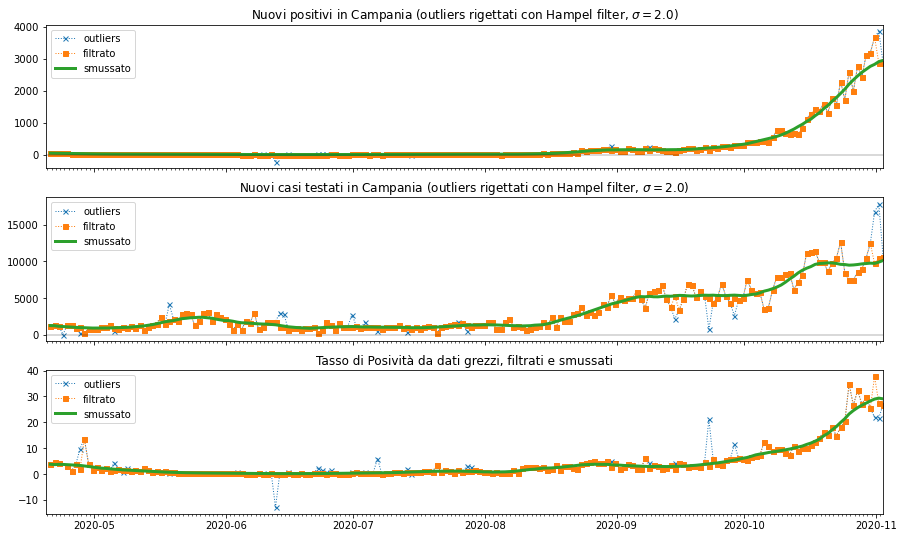

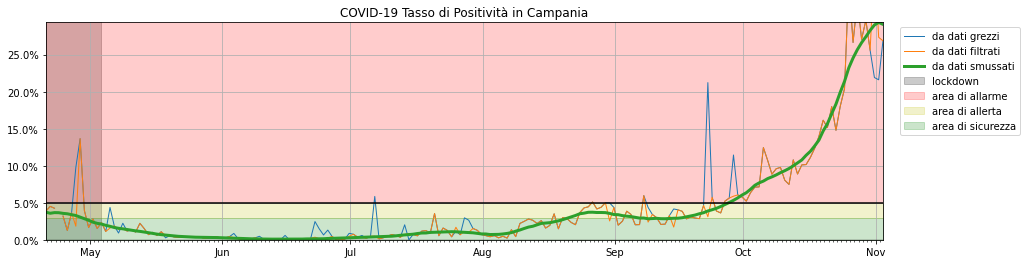

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,26.868896,26.868896,29.093451
2020-11-01 17:00:00,21.606493,27.343974,29.360296
2020-10-31 17:00:00,21.909710,37.770229,29.003739
2020-10-30 17:00:00,25.584197,25.584197,28.279066
2020-10-29 17:00:00,29.656886,29.656886,27.418413
2020-10-28 17:00:00,27.071946,27.071946,26.618228
2020-10-27 17:00:00,32.326425,32.326425,25.668991


***

## Emilia-Romagna

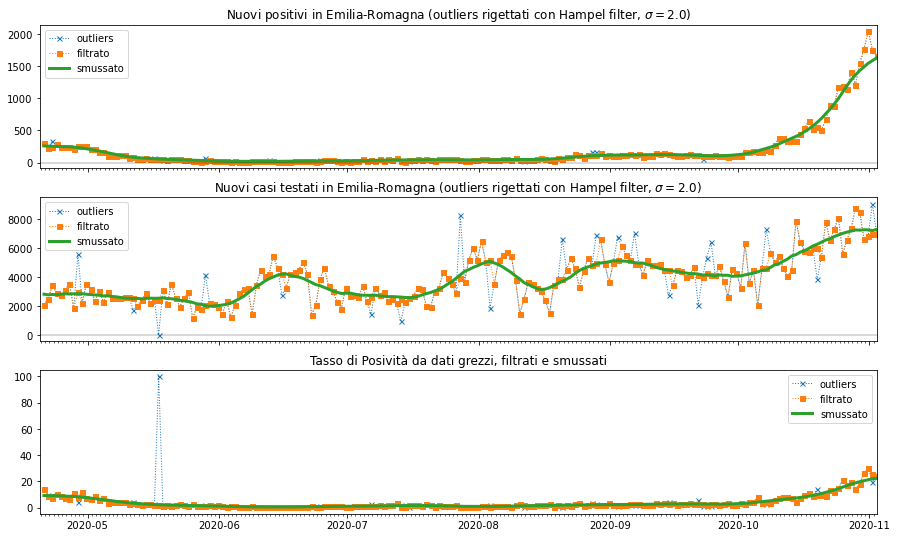

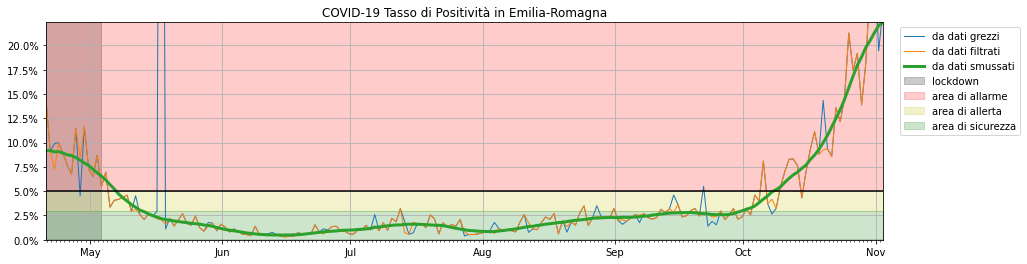

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,23.797177,23.797177,22.365927
2020-11-01 17:00:00,19.425414,25.324114,22.025091
2020-10-31 17:00:00,29.859895,29.859895,21.301413
2020-10-30 17:00:00,26.499324,26.499324,20.503677
2020-10-29 17:00:00,18.227938,18.227938,19.793213
2020-10-28 17:00:00,13.868864,13.868864,18.810232
2020-10-27 17:00:00,19.182731,19.182731,17.948194


***

## Friuli Venezia Giulia

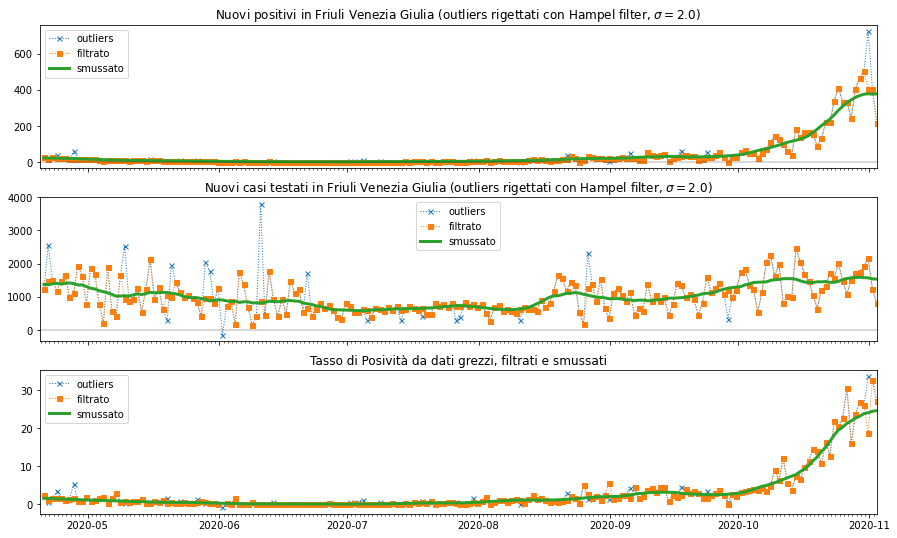

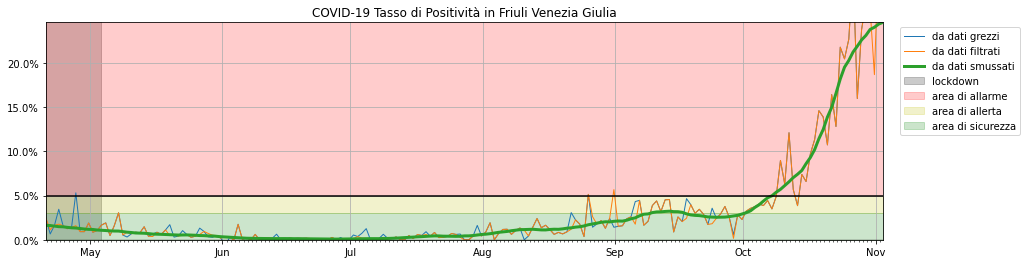

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,27.114428,27.114428,24.619871
2020-11-01 17:00:00,32.737612,32.737612,24.424465
2020-10-31 17:00:00,33.564494,18.700878,24.063759
2020-10-30 17:00:00,26.111686,26.111686,23.820791
2020-10-29 17:00:00,26.804124,26.804124,23.138342
2020-10-28 17:00:00,23.812317,23.812317,22.630806
2020-10-27 17:00:00,15.992037,15.992037,21.924429


***

## Lazio

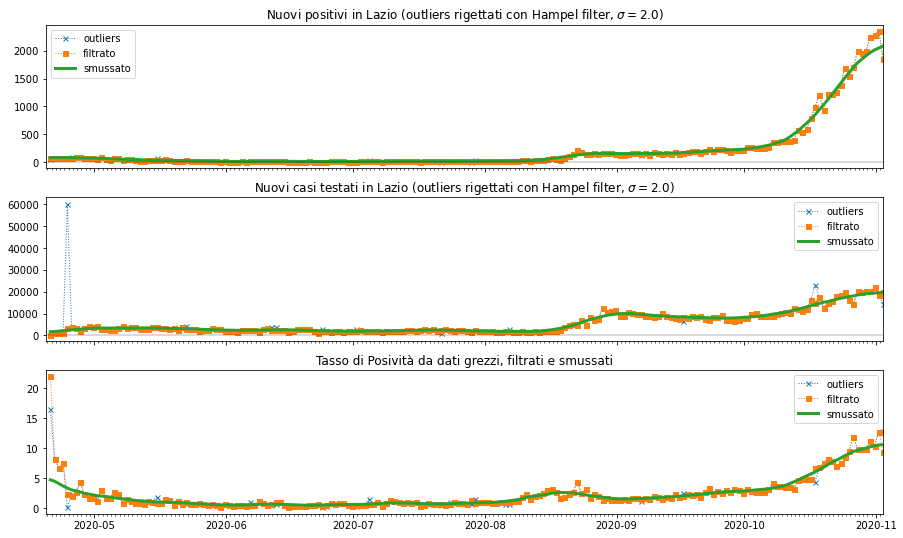

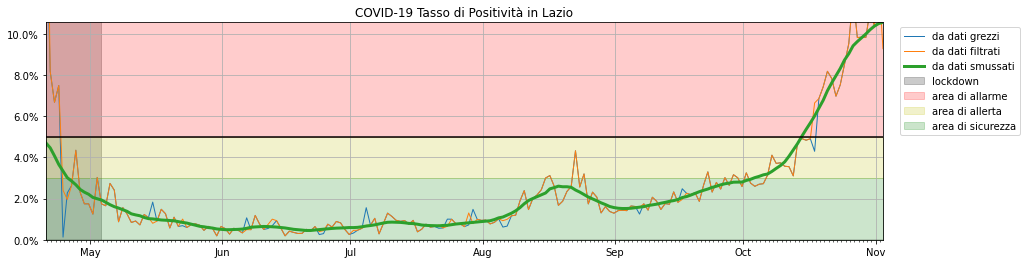

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,12.755592,9.281078,10.560871
2020-11-01 17:00:00,12.721173,12.721173,10.502793
2020-10-31 17:00:00,10.380482,10.380482,10.378624
2020-10-30 17:00:00,11.167462,11.167462,10.206579
2020-10-29 17:00:00,9.833399,9.833399,9.998137
2020-10-28 17:00:00,9.840586,9.840586,9.813318
2020-10-27 17:00:00,9.823541,9.823541,9.626984


***

## Liguria

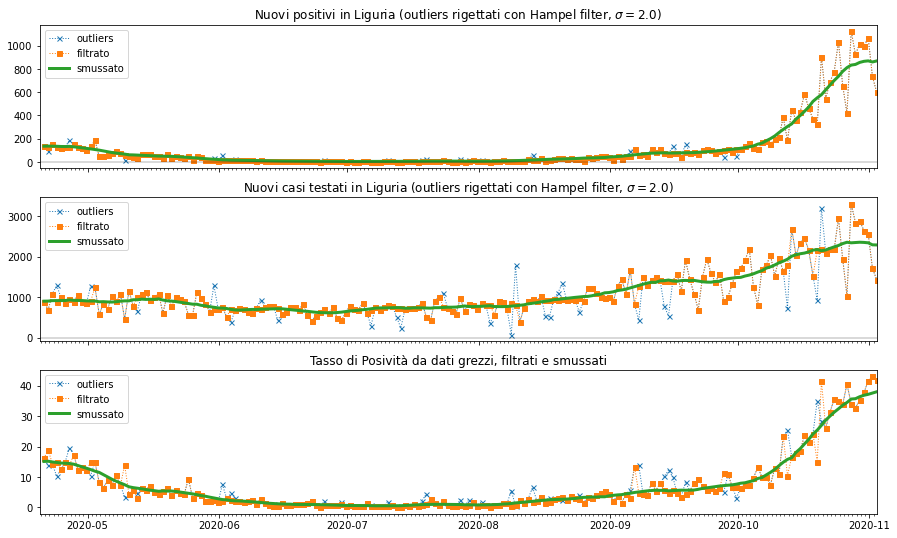

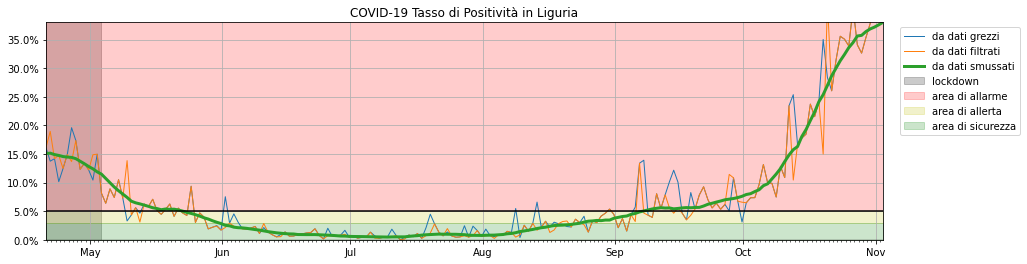

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,41.858840,41.858840,38.018019
2020-11-01 17:00:00,43.066121,43.066121,37.585744
2020-10-31 17:00:00,41.572596,41.572596,37.181326
2020-10-30 17:00:00,37.783661,37.783661,36.864464
2020-10-29 17:00:00,35.322693,35.322693,36.399047
2020-10-28 17:00:00,32.640113,32.640113,35.745879
2020-10-27 17:00:00,34.089534,34.089534,35.631572


***

## Lombardia

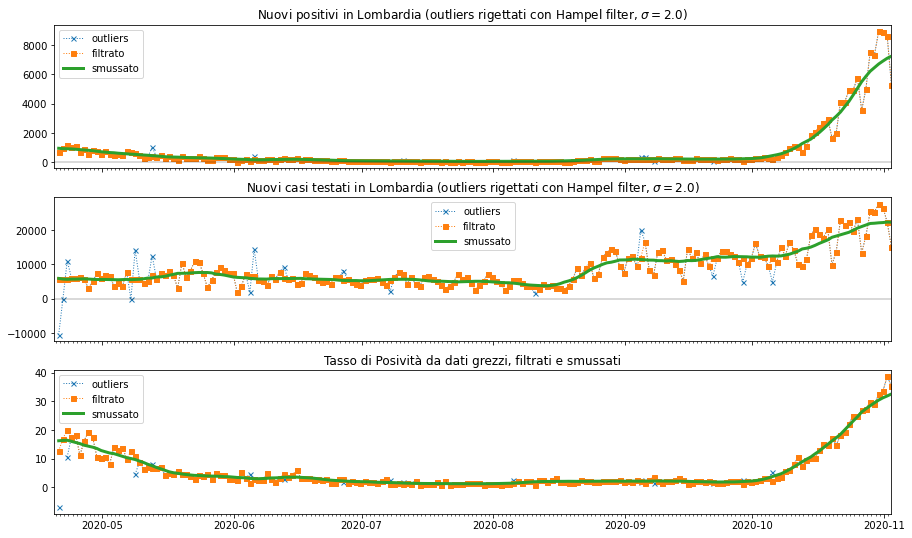

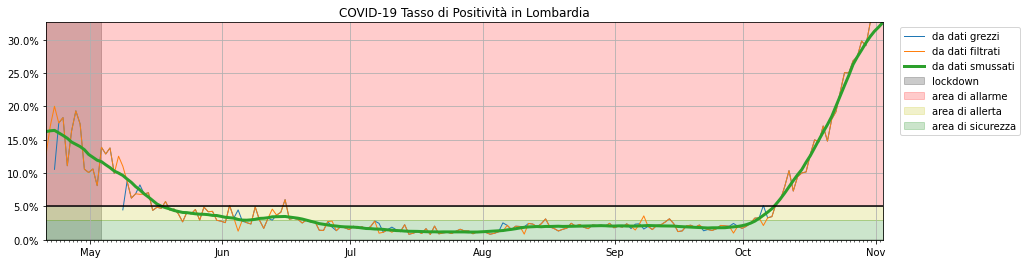

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,35.294904,35.294904,32.598179
2020-11-01 17:00:00,38.728402,38.728402,31.894010
2020-10-31 17:00:00,33.687113,33.687113,31.259646
2020-10-30 17:00:00,32.488488,32.488488,30.454803
2020-10-29 17:00:00,29.098767,29.098767,29.511590
2020-10-28 17:00:00,29.804014,29.804014,28.454590
2020-10-27 17:00:00,27.471628,27.471628,27.430844


***

## Marche

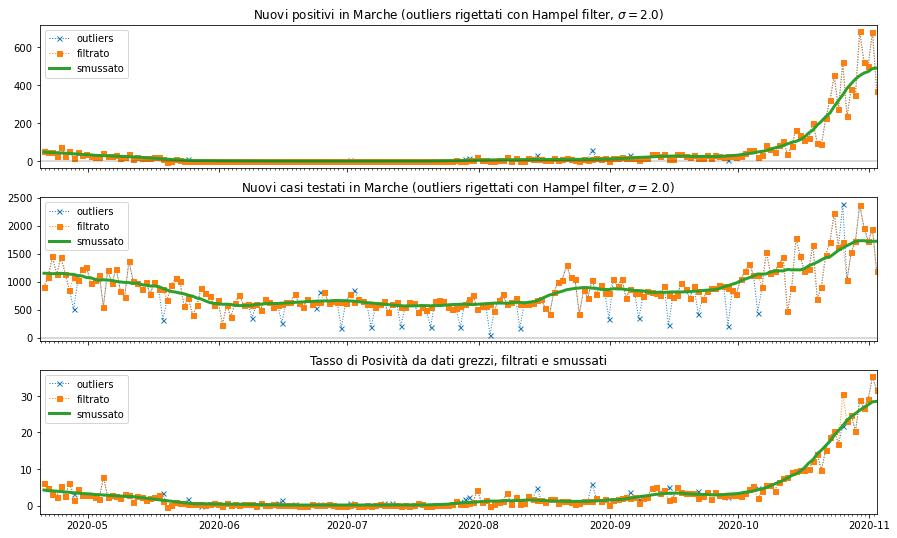

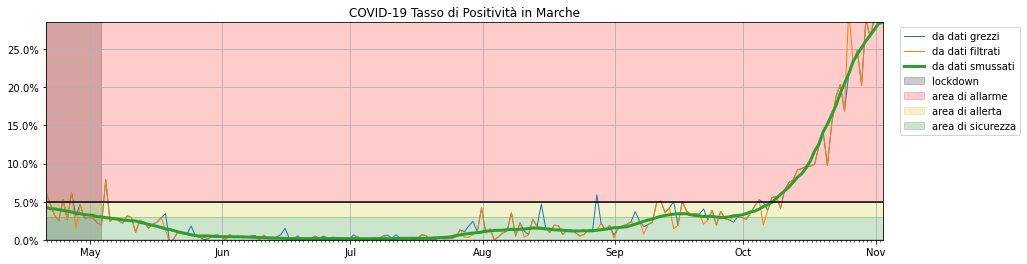

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,31.503378,31.503378,28.521329
2020-11-01 17:00:00,35.315408,35.315408,28.378162
2020-10-31 17:00:00,29.050926,29.050926,27.580930
2020-10-30 17:00:00,26.626016,26.626016,26.820570
2020-10-29 17:00:00,28.920742,28.920742,26.073542
2020-10-28 17:00:00,20.277296,20.277296,25.216345
2020-10-27 17:00:00,24.869110,24.869110,24.328117


***

## Molise

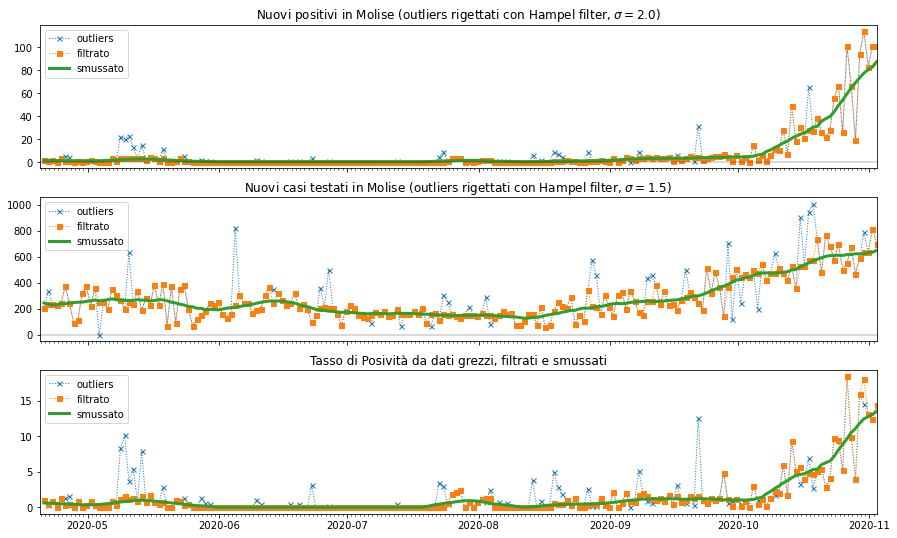

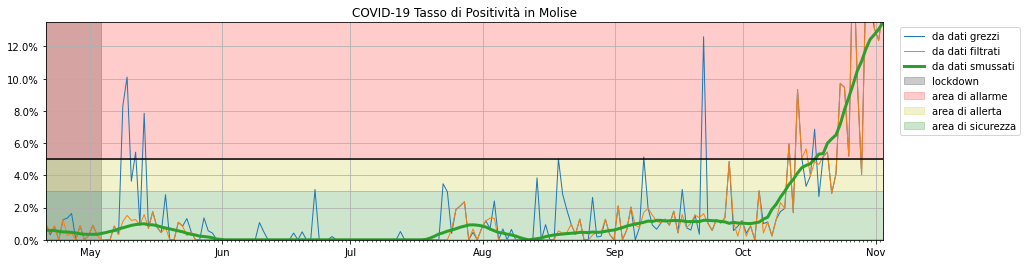

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,14.407989,14.407989,13.494345
2020-11-01 17:00:00,12.377451,12.377451,13.064122
2020-10-31 17:00:00,13.112164,13.112164,12.738304
2020-10-30 17:00:00,14.467005,18.009479,12.441116
2020-10-29 17:00:00,15.932203,15.932203,11.834711
2020-10-28 17:00:00,4.042553,4.042553,11.078701
2020-10-27 17:00:00,9.836066,9.836066,10.491915


***

## P.A. Bolzano

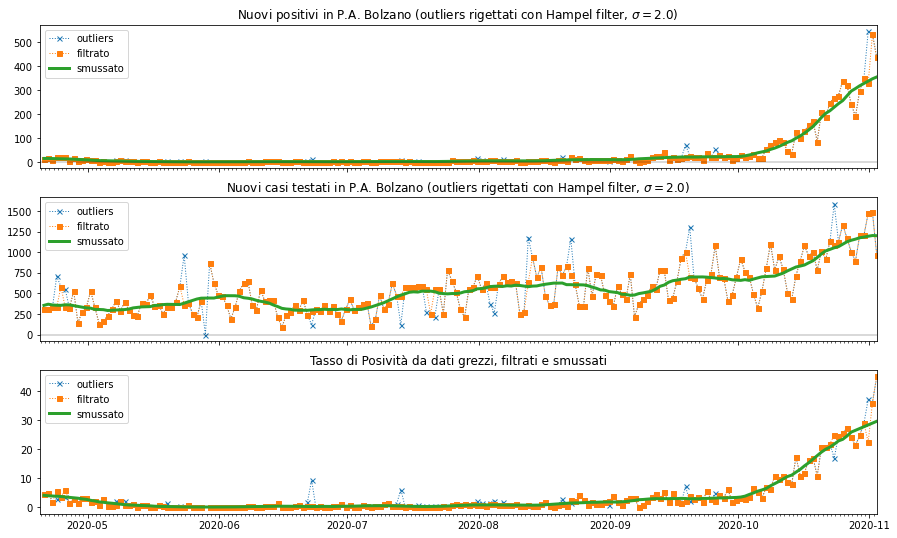

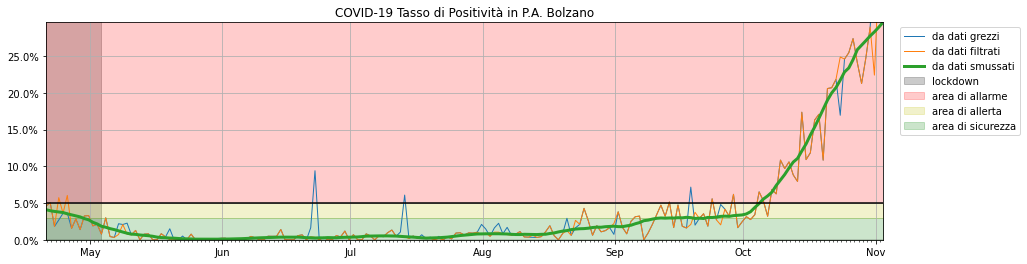

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,45.051546,45.051546,29.599198
2020-11-01 17:00:00,36.032389,36.032389,28.927132
2020-10-31 17:00:00,37.160326,22.418478,28.304194
2020-10-30 17:00:00,28.973510,28.973510,27.749094
2020-10-29 17:00:00,24.771405,24.771405,27.107061
2020-10-28 17:00:00,21.276596,21.276596,26.496060
2020-10-27 17:00:00,24.103586,24.103586,25.883041


***

## P.A. Trento

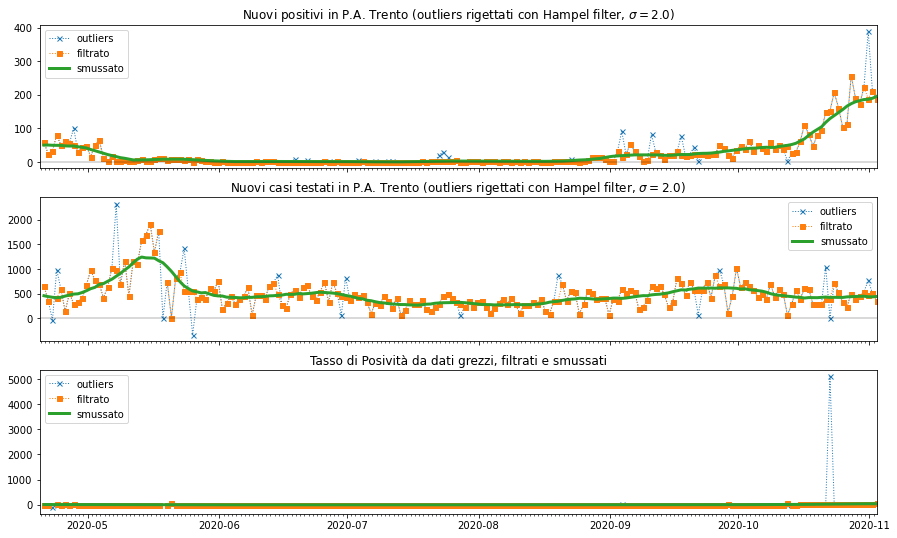

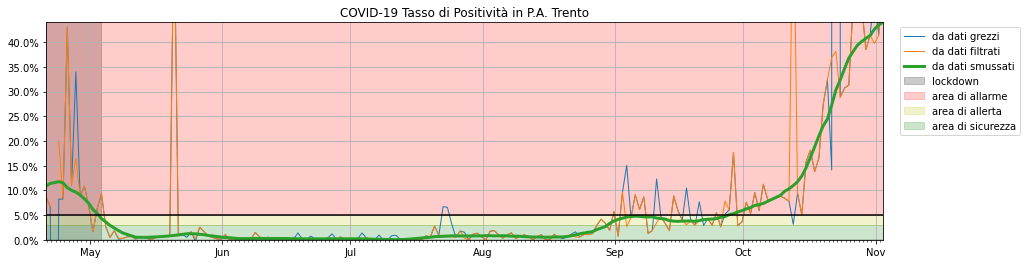

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,52.974504,52.974504,44.026348
2020-11-01 17:00:00,41.420118,41.420118,43.496979
2020-10-31 17:00:00,50.452781,39.747634,42.638421
2020-10-30 17:00:00,41.417910,41.417910,41.366964
2020-10-29 17:00:00,38.530067,38.530067,40.786797
2020-10-28 17:00:00,47.630923,47.630923,40.137199
2020-10-27 17:00:00,51.195219,51.195219,39.380677


***

## Piemonte

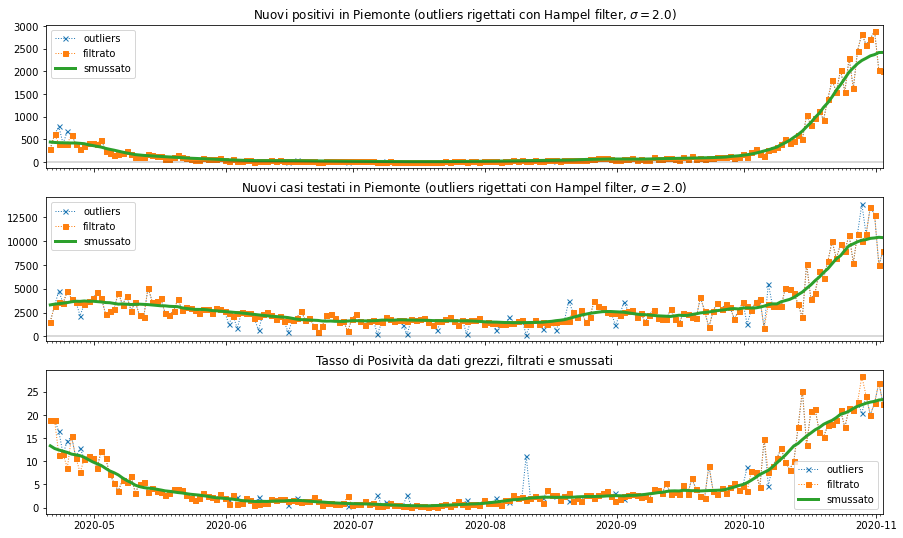

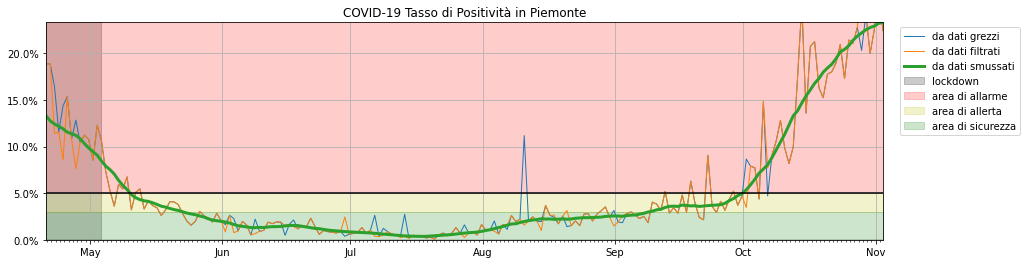

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,22.422478,22.422478,23.312184
2020-11-01 17:00:00,26.911315,26.911315,23.204453
2020-10-31 17:00:00,22.591752,22.591752,22.917776
2020-10-30 17:00:00,19.986769,19.986769,22.753863
2020-10-29 17:00:00,24.156621,24.156621,22.513978
2020-10-28 17:00:00,20.300158,28.292634,22.181396
2020-10-27 17:00:00,22.774020,22.774020,21.838794


***

## Puglia

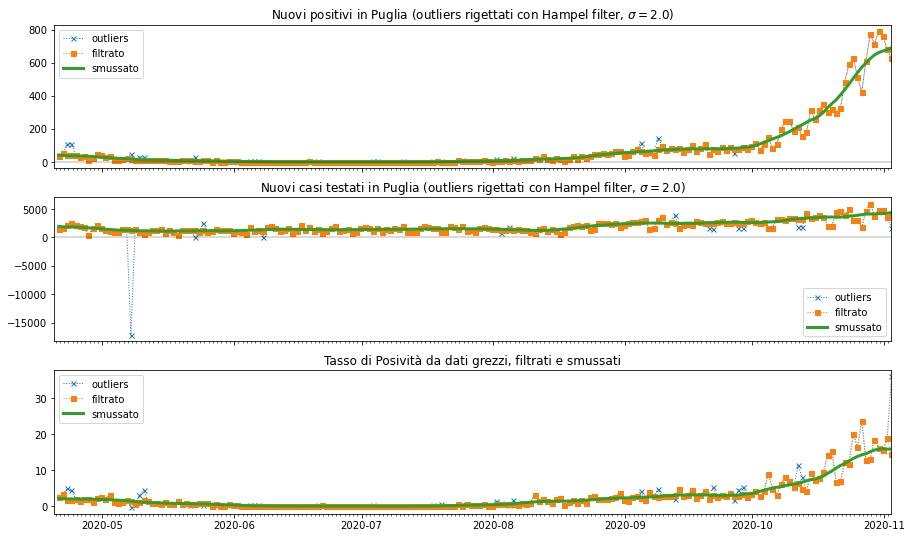

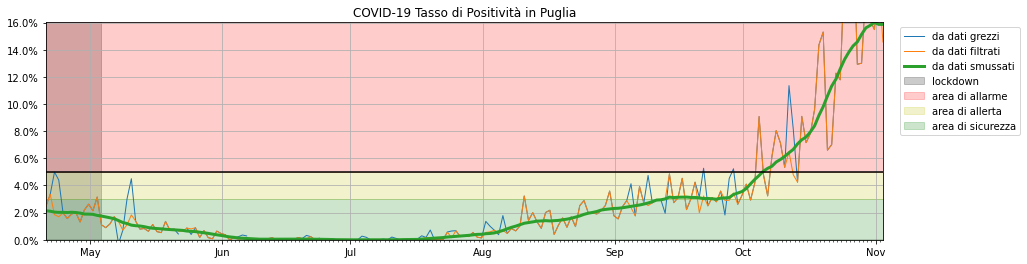

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,36.039148,14.569999,15.866450
2020-11-01 17:00:00,18.899389,18.899389,15.863849
2020-10-31 17:00:00,15.481512,15.481512,16.013861
2020-10-30 17:00:00,16.172562,16.172562,15.790001
2020-10-29 17:00:00,18.520435,18.520435,15.608901
2020-10-28 17:00:00,13.009774,13.009774,15.131387
2020-10-27 17:00:00,12.925746,12.925746,14.572870


***

## Sardegna

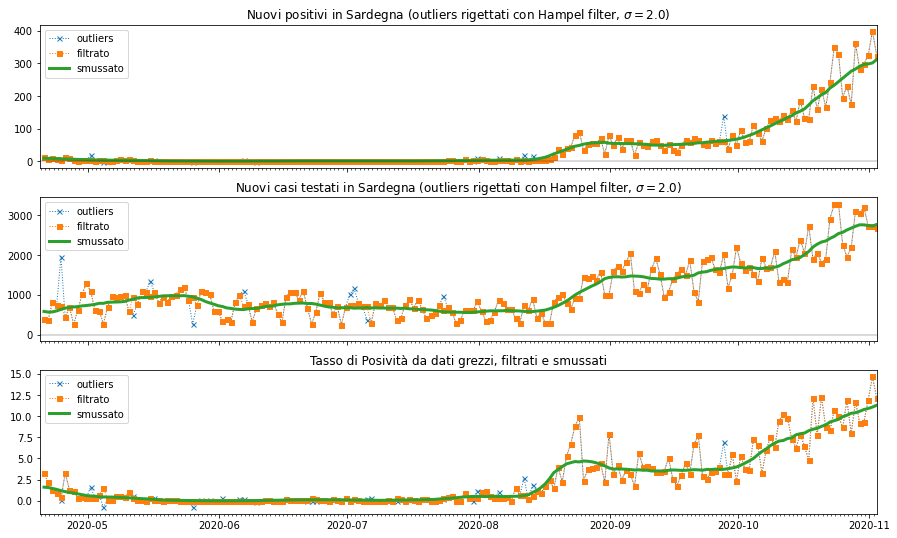

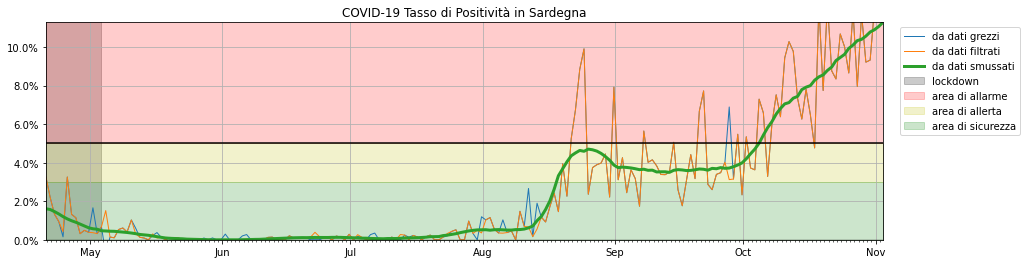

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,12.080537,12.080537,11.276450
2020-11-01 17:00:00,14.674513,14.674513,11.060589
2020-10-31 17:00:00,11.944138,11.944138,10.892631
2020-10-30 17:00:00,9.318324,9.318324,10.774920
2020-10-29 17:00:00,9.212676,9.212676,10.562409
2020-10-28 17:00:00,11.707633,11.707633,10.395860
2020-10-27 17:00:00,7.952468,7.952468,10.331097


***

## Sicilia

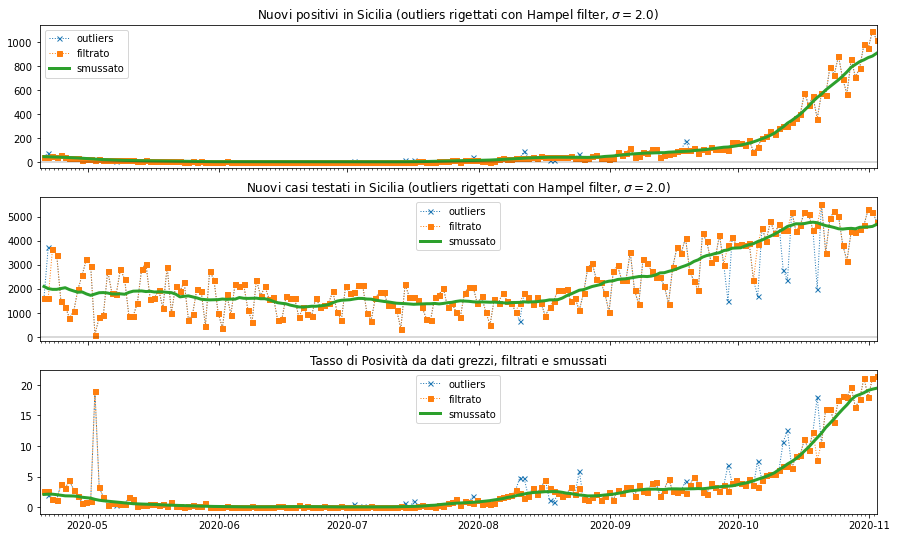

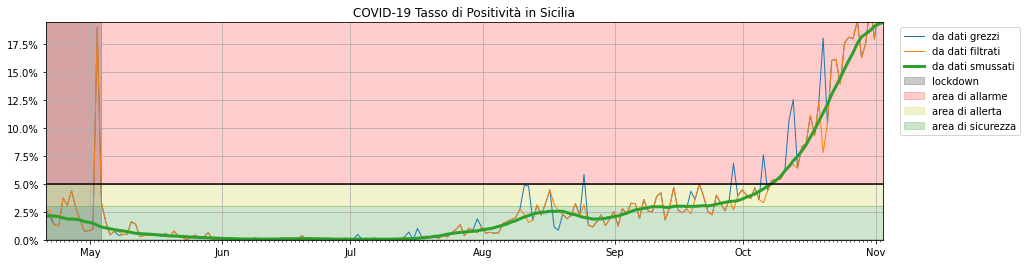

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,21.377871,21.377871,19.453311
2020-11-01 17:00:00,21.098266,21.098266,19.298759
2020-10-31 17:00:00,17.952103,17.952103,19.105793
2020-10-30 17:00:00,21.165842,21.165842,18.714343
2020-10-29 17:00:00,17.643113,17.643113,18.426713
2020-10-28 17:00:00,16.305850,16.305850,18.160562
2020-10-27 17:00:00,19.585516,19.585516,17.573873


***

## Toscana

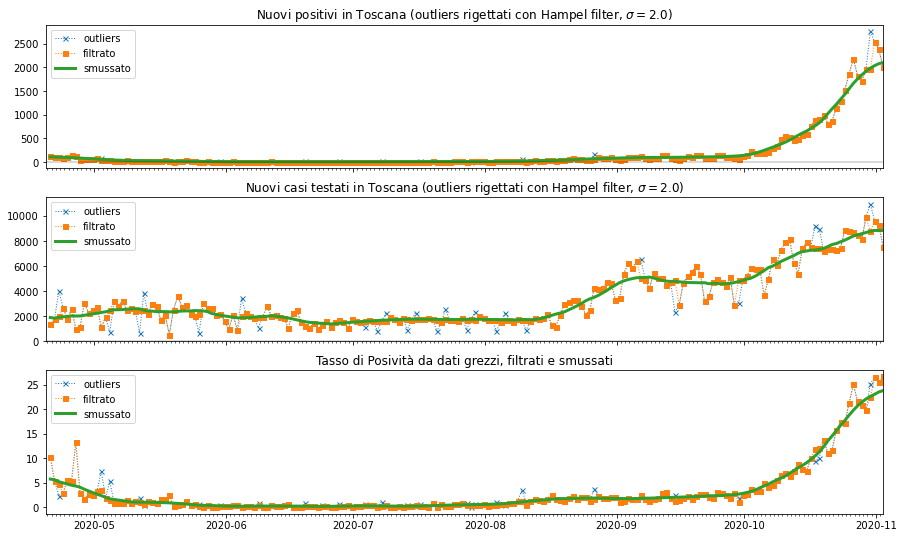

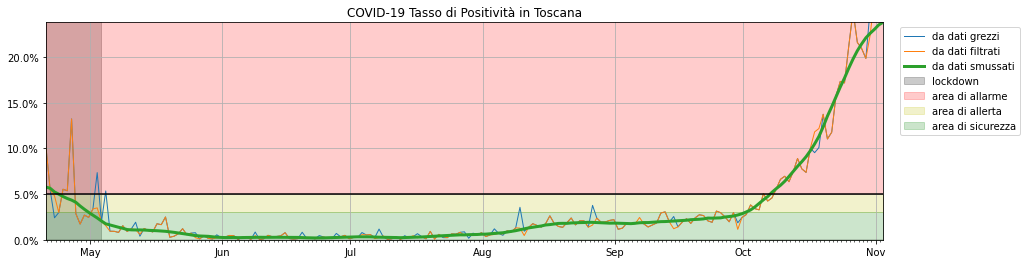

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,26.672862,26.672862,23.796657
2020-11-01 17:00:00,25.555914,25.555914,23.512916
2020-10-31 17:00:00,26.488685,26.488685,23.030973
2020-10-30 17:00:00,25.218898,22.389250,22.598676
2020-10-29 17:00:00,19.850565,19.850565,22.101435
2020-10-28 17:00:00,20.941638,20.941638,21.433518
2020-10-27 17:00:00,21.602086,21.602086,20.685381


***

## Umbria

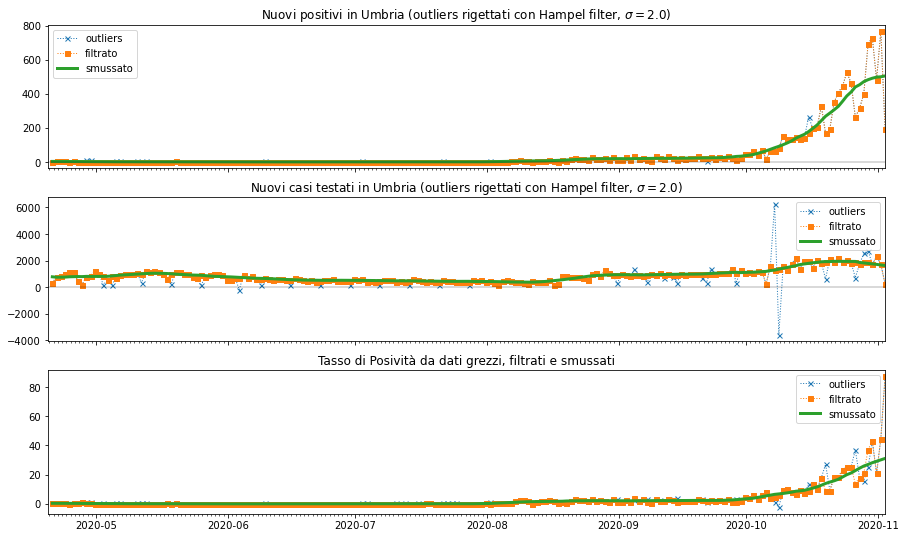

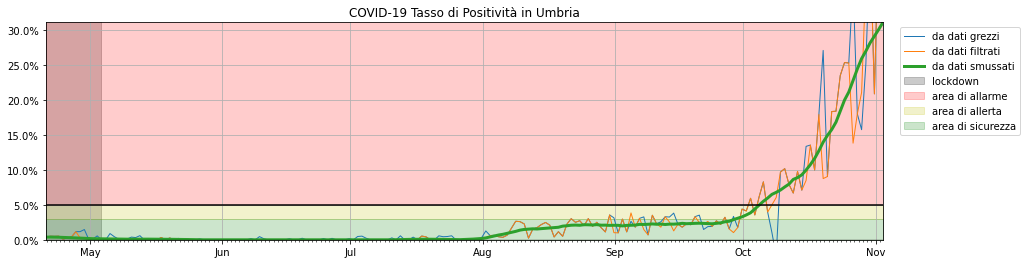

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,87.330317,87.330317,31.127774
2020-11-01 17:00:00,44.625218,44.625218,30.110609
2020-10-31 17:00:00,20.891003,20.891003,29.154695
2020-10-30 17:00:00,42.831962,42.831962,28.203456
2020-10-29 17:00:00,25.199710,37.211796,27.014189
2020-10-28 17:00:00,15.762579,21.094161,25.940320
2020-10-27 17:00:00,18.025258,18.025258,24.450921


***

## Valle d'Aosta

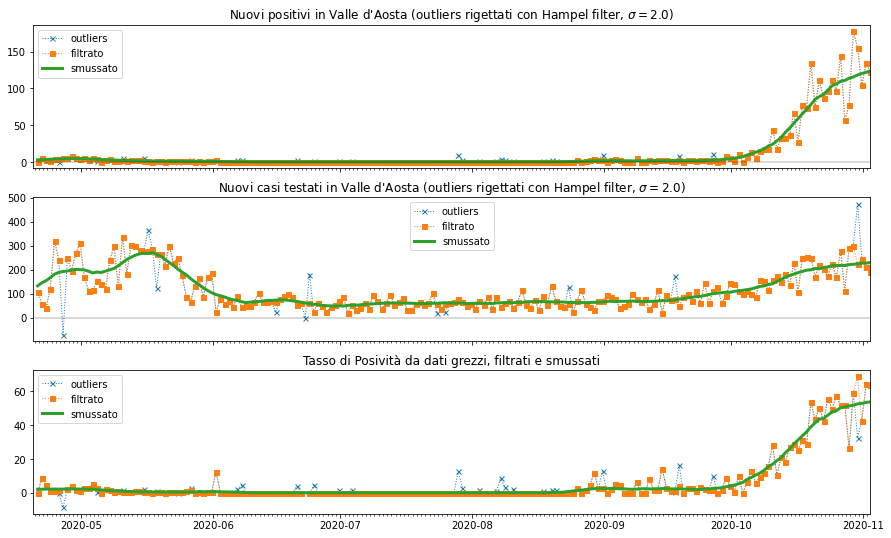

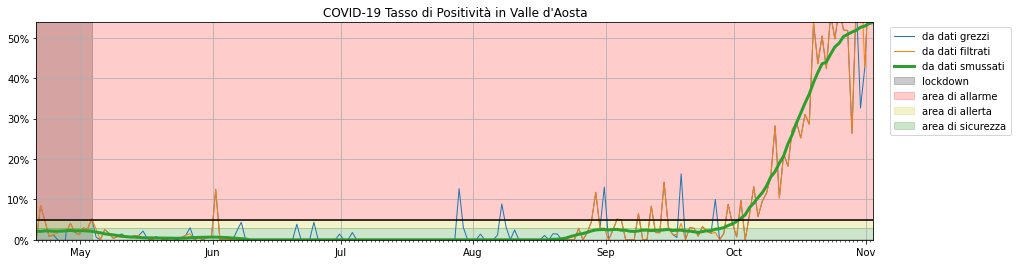

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,63.541667,63.541667,53.843807
2020-11-01 17:00:00,64.285714,64.285714,53.524635
2020-10-31 17:00:00,42.622951,42.622951,52.917940
2020-10-30 17:00:00,32.631579,68.888889,52.618626
2020-10-29 17:00:00,59.333333,59.333333,51.870794
2020-10-28 17:00:00,26.369863,26.369863,51.444159
2020-10-27 17:00:00,51.818182,51.818182,50.865489


***

## Veneto

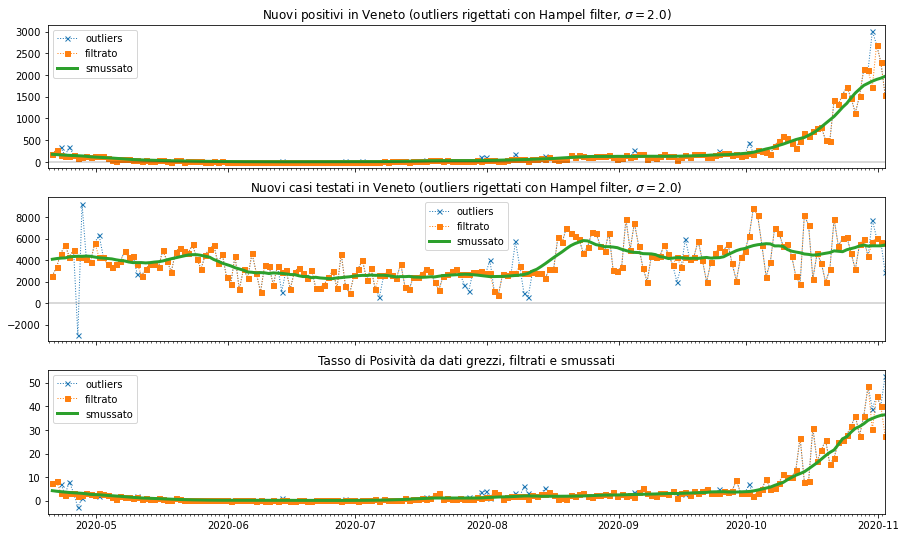

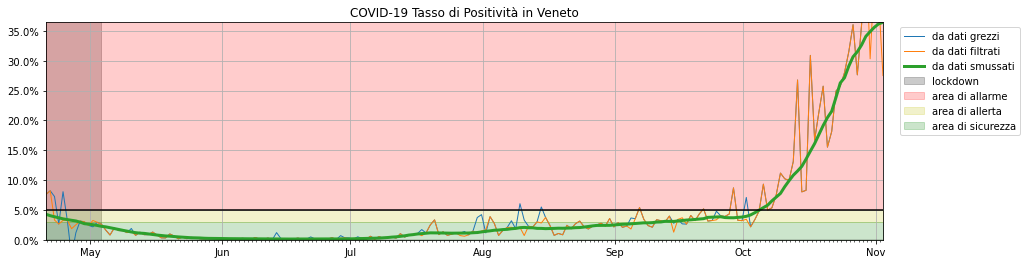

,PP grezzo,PP filtrato,PP smussato
data,,,
2020-11-02 17:00:00,52.660300,27.507572,36.420937
2020-11-01 17:00:00,40.329651,40.329651,36.171206
2020-10-31 17:00:00,44.213115,44.213115,35.604303
2020-10-30 17:00:00,38.965071,30.317377,34.869937
2020-10-29 17:00:00,48.572087,48.572087,34.081954
2020-10-28 17:00:00,36.071368,36.071368,32.638322
2020-10-27 17:00:00,27.629911,27.629911,31.499492


***

In [7]:
latest = {
    "regione": [],
    "PP grezzo": [],
    "PP filtrato": [],
    "PP smussato": []
}
sommario = {}

for region in countries:
    display(Markdown(f"## {region}"))
    ok = ko.loc[region]
    
    n_sigmas_pos = 2.0
    n_sigmas_tst = 2.0
    #if region == ["Valle d'Aosta"]:
    #    n_sigmas_pos = 5.0
    if region in ["Basilicata", "Molise"]:
        n_sigmas_tst = 1.5
    if ok['nuovi_positivi'][1:].max() > 30:
        pos, pos_outs = hampel_filter_pandas(ok['nuovi_positivi'][1:], 7, n_sigmas=n_sigmas_pos)
        rig = f"(outliers rigettati con Hampel filter, $\sigma={n_sigmas_pos}$)"
    else:
        pos = ok['nuovi_positivi'][1:]
        rig = "(outliers non rigettati)"
    tst, tst_outs = hampel_filter_pandas(ok['casi_testati'].diff()[1:], 7, n_sigmas=n_sigmas_tst)
    tst[tst<=0] = np.nan
    
    pos_sm = pos.rolling(14,
                    win_type='gaussian',
                    min_periods=1,
                    center=True).mean(std=5).values
    tst_sm = tst.rolling(14,
                    win_type='gaussian',
                    min_periods=1,
                    center=True).mean(std=5).values
    
    grezzi = ok['nuovi_positivi'][1:] / ok['casi_testati'].diff()[1:] * 100
    filtrati = pos / tst * 100
    smussati = pos_sm / tst_sm * 100
    
    if region == "P.A. Trento":
        smussati[smussati>60] = np.nan

    smooth = pd.Series(smussati).rolling(14,
                    win_type='gaussian',
                    min_periods=1,
                    center=True).mean(std=5).values
    
    sommario.update({region: smooth})

    fig, ax = plt.subplots(3, 1, figsize=(15, 9), sharex=True)

    ax[0].plot(ok['nuovi_positivi'][1:], 'x:', ms=5, lw=1, label="outliers")
    ax[0].plot(pos, 's:', ms=5, lw=1, label="filtrato")
    ax[0].plot(pos.index, pos_sm, lw=3, label="smussato")
    ax[0].axhline(0, c="k", alpha=.2)
    ax[0].legend()
    ax[0].set_title(f"Nuovi positivi in {region} {rig}")

    ax[1].plot(ok['casi_testati'].diff()[1:], 'x:', ms=5, lw=1, label="outliers")
    ax[1].plot(tst, 's:', ms=5, lw=1, label="filtrato")
    ax[1].plot(tst.index, tst_sm, lw=3, label="smussato")
    ax[1].axhline(0, c="k", alpha=.2)
    ax[1].legend()

    ax[1].set_xlim(days[0], days[-1])
    ax[1].xaxis.set_major_locator(mdates.MonthLocator())
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax[1].xaxis.set_minor_locator(mdates.DayLocator())
    ax[1].set_title(f"Nuovi casi testati in {region} (outliers rigettati con Hampel filter, $\sigma={n_sigmas_tst}$)")

    ax[2].plot(grezzi, 'x:', ms=5, lw=1, label="outliers")
    ax[2].plot(filtrati, 's:', ms=5, lw=1, label="filtrato")
    ax[2].plot(filtrati.index, smussati, lw=3, label="smussato")
    
    #ax[2].plot(grezzo.index, grezzo, 'o:', label="PP da dati grezzi")
    #ax[2].plot(grezzo.index, indice, lw=3, label="PP da dati filtrati")
    ax[2].legend()
    ax[2].set_title("Tasso di Posività da dati grezzi, filtrati e smussati")
    
    plt.show()
    plt.close(fig="all")

    latest["regione"].append(region)
    latest["PP grezzo"].append(grezzi[-1])
    latest["PP filtrato"].append(filtrati[-1])
    latest["PP smussato"].append(smussati[-1])
    
    fig, ax = plt.subplots(figsize=(15, 4))

    ax.plot(grezzi, label="da dati grezzi", lw=1)
    ax.plot(filtrati, label="da dati filtrati", lw=1)
    ax.plot(grezzi.index, smussati, lw=3, label="da dati smussati")

    ax.axhline(0, c="k", alpha=.2)
    #ax.hlines(np.arange(0,15,1), grezzo.index[0], grezzo.index[-1], color="k", alpha=.2)
    ax.grid()

    ax.axhline(5, c="k")

    ax.fill_betweenx(
        [0,100],
        grezzo.index[grezzo.index>=pd.to_datetime("2020-03-11")][0],
        grezzo.index[grezzo.index<=pd.to_datetime("2020-05-04")][-1],
        color="k", alpha=.2, label="lockdown"
    )

    ax.fill_between(grezzo.index, 5, 100, color="r", alpha=.2, label="area di allarme")
    ax.fill_between(grezzo.index, 3, 5, color="y", alpha=.2, label="area di allerta")
    ax.fill_between(grezzo.index, 0, 3, color="g", alpha=.2, label="area di sicurezza")


    #ax.set_yticks(np.arange(0,15,1))
    #ax.set_yticklabels([f"{p:.0%}" for p in np.arange(0,.15,.01)])
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_ylim(0, max(smussati.max(), 6))
    ax.set_xlim(grezzo.index[0], grezzo.index[-1])
    
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.legend(loc="upper right", bbox_to_anchor=(1.17,1))
    ax.set_title(f"COVID-19 Tasso di Positività in {region}")
    plt.show()
    plt.close(fig="all")
    
    idf = pd.DataFrame({
        "data": grezzo.index[-7:],
        "PP grezzo": grezzi.values[-7:],
        "PP filtrato": filtrati.values[-7:],
        "PP smussato": smussati[-7:]
    })
    idf.set_index('data', inplace=True)
    display(HTML(idf[::-1].to_html()))
    display(Markdown("***"))

# SOMMARIO

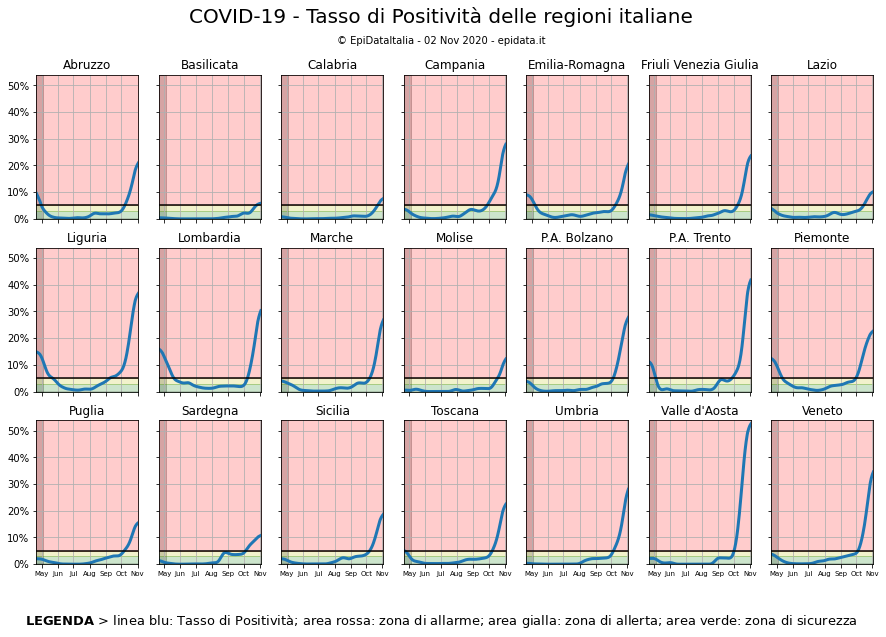

In [8]:
nrows = 3
ncols = 7

max_PP = max(max(latest['PP smussato']), .06)

fig, ax = plt.subplots(nrows, ncols, figsize=(15, 3*nrows), sharex=True, sharey=True)
for i, region in enumerate(sommario):
    ok = ko.loc[region]
    
    ax.flat[i].plot(grezzi.index, sommario[region], lw=3, label="PP")

    ax.flat[i].axhline(0, c="k", alpha=.2)
    #ax.flat[i].hlines(np.arange(0,15,1), grezzi.index[0], grezzi.index[-1], color="k", alpha=.2)
    ax.flat[i].grid()

    ax.flat[i].axhline(5, c="k")

    ax.flat[i].fill_betweenx(
        [0, max_PP],
        grezzi.index[grezzi.index>=pd.to_datetime("2020-03-11")][0],
        grezzi.index[grezzi.index<=pd.to_datetime("2020-05-04")][-1],
        color="k", alpha=.2, label="lockdown"
    )

    ax.flat[i].fill_between(grezzi.index, 5, max_PP, color="r", alpha=.2, label="area di allarme")
    ax.flat[i].fill_between(grezzi.index, 3, 5, color="y", alpha=.2, label="area di allerta")
    ax.flat[i].fill_between(grezzi.index, 0, 3, color="g", alpha=.2, label="area di sicurezza")

    #ax.set_yticks(np.arange(0,15,1))
    #ax.set_yticklabels([f"{p:.0%}" for p in np.arange(0,.15,.01)])
    ax.flat[i].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.flat[i].set_ylim(0, max_PP)
    ax.flat[i].set_xlim(grezzi.index[0], grezzi.index[-1])
    
    ax.flat[i].xaxis.set_major_locator(mdates.MonthLocator())
    ax.flat[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.flat[i].tick_params(axis='x', which='major', labelsize=7)
    #ax.flat[i].xaxis.set_minor_locator(mdates.DayLocator())
    
    #ax.legend(loc="upper right", bbox_to_anchor=(1.17,1))
    ax.flat[i].set_title(f"{region}")

fig.suptitle("COVID-19 - Tasso di Positività delle regioni italiane", fontsize=20, y=0.985)
fig.text(0.5, 0.94, f"© EpiDataItalia - {dt.datetime.now().strftime('%d %b %Y')} - epidata.it", ha="center", va="top")
fig.text(0.5, 0.05, r"$\mathbf{LEGENDA}$ > linea blu: Tasso di Positività; area rossa: zona di allarme; area gialla: zona di allerta; area verde: zona di sicurezza",
    fontsize=13, ha="center", va="top")

#plt.tight_layout()
fig.set_facecolor('w')
fig.savefig("PP.png")
plt.show()
plt.close(fig="all")

In [9]:
display(Markdown(f"## Ultimo PP"))
ldf = pd.DataFrame(latest)
ldf.set_index('regione', inplace=True)
display(HTML(ldf.to_html()))

## Ultimo PP

,PP grezzo,PP filtrato,PP smussato
regione,,,
Abruzzo,23.374083,23.374083,22.240059
Basilicata,6.946183,6.946183,6.053326
Calabria,10.409836,10.409836,8.306006
Campania,26.868896,26.868896,29.093451
Emilia-Romagna,23.797177,23.797177,22.365927
Friuli Venezia Giulia,27.114428,27.114428,24.619871
Lazio,12.755592,9.281078,10.560871
Liguria,41.858840,41.858840,38.018019
Lombardia,35.294904,35.294904,32.598179


In [10]:
last_PPs = pd.DataFrame(sommario)[-14:].melt()

In [11]:
last_PPs.columns = ['regione', 'PP']

In [12]:
order = last_PPs.groupby('regione')['PP'].median().sort_values().index

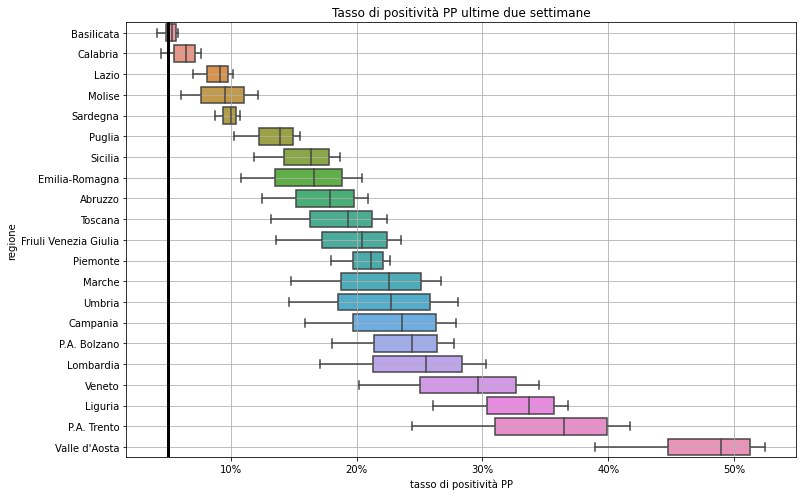

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(
    data=last_PPs,
    y='regione', x='PP',
    order=order,
    ax=ax
)
ax.axvline(5, lw=3, color='k')
ax.grid()
ax.set(
    title='Tasso di positività PP ultime due settimane',
    xlabel='tasso di positività PP'
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
fig.set_facecolor('w')
fig.savefig("PP_regioni.png")
plt.show()
plt.close(fig="all")